# Visualization of Bicycle Crossing Fremont Bridge and Prediction of People's Habits by Unsupervised Clustering

The [bicycle counters on the Seattle Fremont Bridge](http://www.seattle.gov/transportation/bikecounter_fremont.htm) provide valuable information about the patterns of cycling in Seattle, and an accurate count of the number of cyclists at one of the busiest cycling locations in Seattle. 

The data is collected hourly by the Fremont Bridge bicycle counters at East sidewalk and West sidewalk

The data can be downloaded from url: 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'

In [1]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

import os
from urllib.request import urlretrieve

## Download Data

In [2]:
# Define a function called get_data_fromurl to download the data from a given url and save the data as a given filename
def get_data_fromurl(filename, url, force_download=False):
    """Download and cache the url data
    Parameters
    ----------
    filename : string (optional)
        location to save the data
    url : string (optional)
        web location of the data
    force_download : bool (optional)
        if True, force redownload of data
    Returns
    -------
    data : pandas.DataFrame
        The fremont bridge data
    """
    if force_download or not os.path.exists(filename):
        urlretrieve(url, filename)
    #data = pd.read_csv(filename, index_col='Date', parse_dates=True)
    data = pd.read_csv(filename, index_col='Date')
    # below is to speed up parse_dates by specifying the format of date in the data file, for more format see "Python strftime reference" online

    try:
        data.index = pd.to_datetime(data.index, format='%m/%d/%Y %I:%M:%S %p')
    except TypeError:
        data.index = pd.to_datetime(data.index)

    return data

In [3]:
# The data is time-series data
Data_URL = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'
data = get_data_fromurl(filename='Fremont.csv', url=Data_URL, force_download=False)

In [4]:
data.shape

(41568, 2)

In [5]:
data.head()

,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk
Date,,
2012-10-03 00:00:00,4.0,9.0
2012-10-03 01:00:00,4.0,6.0
2012-10-03 02:00:00,1.0,1.0
2012-10-03 03:00:00,2.0,3.0
2012-10-03 04:00:00,6.0,1.0


In [6]:
data.tail()

,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk
Date,,
2017-06-30 19:00:00,225.0,82.0
2017-06-30 20:00:00,119.0,43.0
2017-06-30 21:00:00,87.0,38.0
2017-06-30 22:00:00,58.0,22.0
2017-06-30 23:00:00,36.0,13.0


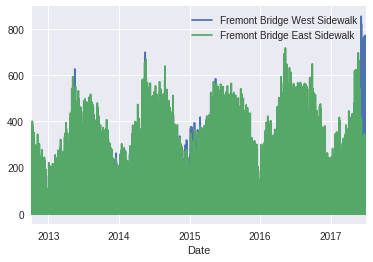

In [7]:
# take a frist look at the data
data.plot();

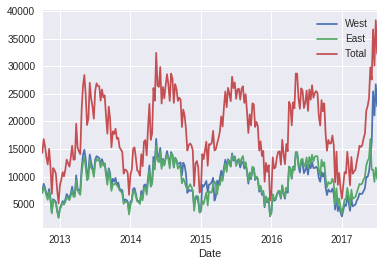

In [8]:
# rename the data columns as 'West' and 'East' for short and add a new culumn 'Total'
data.columns = ['West', 'East']
data['Total'] = data['West'] + data['East']
# resample by week
data.resample('W').sum().plot();

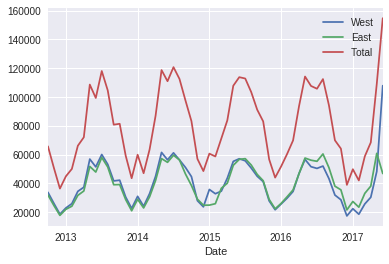

In [9]:
# resample data by month
data.resample('M').sum().plot();

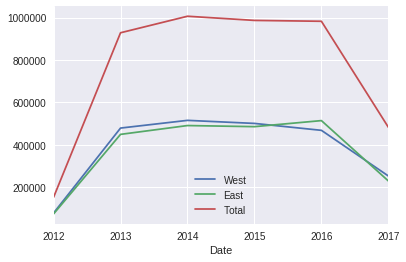

In [10]:
# resample data by year end
data.resample('A').sum().plot();

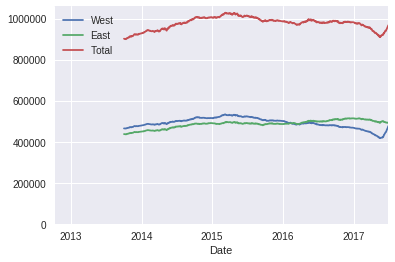

In [11]:
ax = data.resample('D').sum().rolling(365).sum().plot();

ax.set_ylim(0,None);

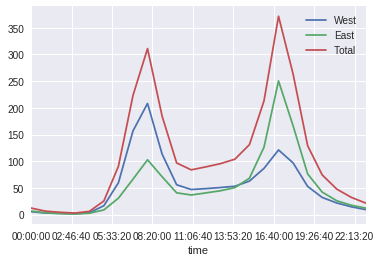

In [12]:
# let's look at the trends in an individual day 
data.groupby(data.index.time).mean().plot();
# some interesting pattern:
# the mean of data grouped by time shows two peaks at 8am and 5pm, respectively
# West side peaks at the morning, while the East side peaks at evening

In [13]:
# create a pivoted table for the whole data set grouped by time, instead of the average as above
pivoted = data.pivot_table('Total', index=data.index.time, columns=data.index.date)
pivoted.iloc[:5,:5]

,2012-10-03,2012-10-04,2012-10-05,2012-10-06,2012-10-07
00:00:00,13.0,18.0,11.0,15.0,11.0
01:00:00,10.0,3.0,8.0,15.0,17.0
02:00:00,2.0,9.0,7.0,9.0,3.0
03:00:00,5.0,3.0,4.0,3.0,6.0
04:00:00,7.0,8.0,9.0,5.0,3.0


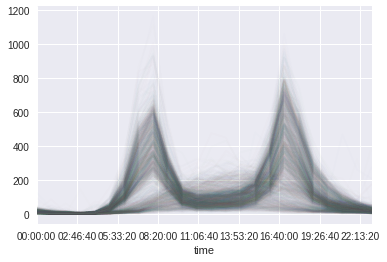

In [14]:
pivoted.plot(legend=False, alpha=0.01);

The above plot shows two kinds of patterns: one with two peaks at 8am and 5pm, respectively; the other one with a single peak at noon. 
The first one is weekdays while the other one is weekends. The following analysis would show the pattern in more details

## PCA

In [15]:
X = pivoted.fillna(0).T
X.shape

(1732, 24)

In [16]:
X2 = PCA(2, svd_solver='full').fit_transform(X)
X2.shape

(1732, 2)

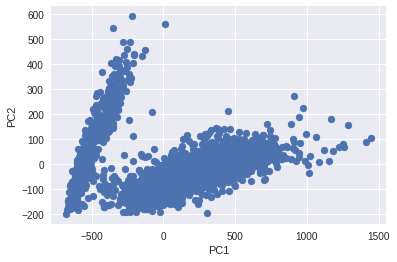

In [17]:
# plot the data on the first two principle components: PC1 and PC2
plt.scatter(X2[:, 0], X2[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2');

We can see that the data can be devided into two groups/clusters

## Unsupervised Clustering

In [18]:
gmm = GaussianMixture(2).fit(X)
labels = gmm.predict(X)

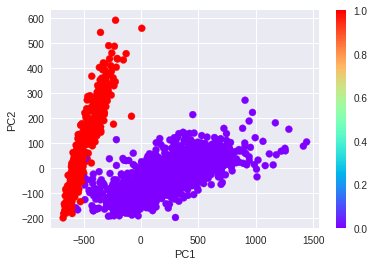

In [19]:
plt.scatter(X2[:, 0], X2[:, 1], c=labels, cmap='rainbow')
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2');

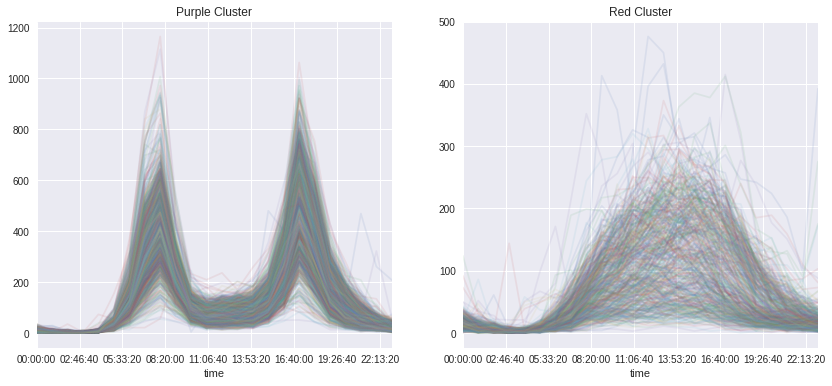

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

pivoted.T[labels == 0].T.plot(legend=False, alpha=0.1, ax=ax[0]);
pivoted.T[labels == 1].T.plot(legend=False, alpha=0.1, ax=ax[1]);

ax[0].set_title('Purple Cluster')
ax[1].set_title('Red Cluster');

## Comparing with Day of Week

In [21]:
# get the day of week
dayofweek = pd.DatetimeIndex(pivoted.columns).dayofweek
dayofweek[0:10]

Int64Index([2, 3, 4, 5, 6, 0, 1, 2, 3, 4], dtype='int64')

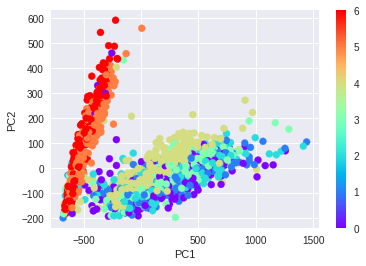

In [22]:
plt.scatter(X2[:, 0], X2[:, 1], c=dayofweek, cmap='rainbow')
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2');

## Analyzing Outliers

In [23]:
dates = pd.DatetimeIndex(pivoted.columns)
dates[(labels == 1) & (dayofweek < 5)]

DatetimeIndex(['2012-11-22', '2012-11-23', '2012-12-24', '2012-12-25',
               '2013-01-01', '2013-05-27', '2013-07-04', '2013-07-05',
               '2013-09-02', '2013-11-28', '2013-11-29', '2013-12-20',
               '2013-12-24', '2013-12-25', '2014-01-01', '2014-04-23',
               '2014-05-26', '2014-07-04', '2014-09-01', '2014-11-27',
               '2014-11-28', '2014-12-24', '2014-12-25', '2014-12-26',
               '2015-01-01', '2015-05-25', '2015-07-03', '2015-09-07',
               '2015-11-26', '2015-11-27', '2015-12-24', '2015-12-25',
               '2016-01-01', '2016-05-30', '2016-07-04', '2016-09-05',
               '2016-11-24', '2016-11-25', '2016-12-26', '2017-01-02',
               '2017-02-06', '2017-05-29'],
              dtype='datetime64[ns]', freq=None)

The above outliers are holidays